In [23]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Load libraries and paths

In [24]:
import sys
sys.path.append("../../")

In [25]:
import numpy as np
import pandas as pd
import geopandas as gpd
import pymc as pm 
import arviz as az
import matplotlib.pyplot as plt
import cloudpickle
import joblib

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score

from config.config import BASE_PATH, PATH_TO_PATH_CONFIG_FILE, PROJECT_EPSG
from src.utils import load_paths_from_yaml, replace_base_path
from src.modeling.encodings import convert_aspect_to_cardinal_direction, apply_encoding, naturraumregionen_encoding
from src.modeling.utils import temporal_train_test_split
from src.modeling.bayesian_models import create_st_blr, create_blr, create_bnn 
from src.modeling.predictions import BinaryClassification, BinaryClassificationBNN

In [26]:
paths = load_paths_from_yaml(PATH_TO_PATH_CONFIG_FILE)
paths = replace_base_path(paths, BASE_PATH)

### Read in data

In [27]:
# read in training data
training_data = gpd.read_file(paths["training_data"])
training_data.date = pd.to_datetime(training_data.date)

# read in Naturraumregionen
naturraumregionen = gpd.read_file(paths["naturraumregionen"])
naturraumregionen.to_crs(PROJECT_EPSG, inplace=True)


In [31]:
fire_samples = training_data[training_data.fire == 1]
non_fire_samples = training_data[training_data.fire == 0]
fire_samples.Pufferradi = fire_samples.Pufferradi.astype("int")
fire_samples = fire_samples[fire_samples.Pufferradi <= 100]
non_fire_samples = non_fire_samples.sample(len(fire_samples))
training_data = pd.concat([fire_samples, non_fire_samples])

c:\Users\b1105474\AppData\Local\miniconda3\envs\pymc_env\Lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


### Data Cleaning & Preparation

In [34]:
# rename columns
training_data.rename(columns={"farmyard_d": "farmyard_density", 
                              "hiking_ds": "hikingtrail_density", 
                              "forest_ds": "forestroad_density", 
                              "rail_dens": "railway_density", 
                              "foresttype": "forest_type", 
                              "pop_dens": "population_density"}, inplace=True)

training_data = training_data.sjoin(naturraumregionen.loc[:, ["EINHEIT", "geometry"]])
training_data.drop(columns=["index_right"], inplace=True)

# create season column (0 = winter (1,2,3), 1 = spring (4,5,6), 2 = sommer (7,8,9), 3 = winter (10,11,12))
training_data["season"] = (training_data.date.dt.month -1) // 3 
training_data["month"] = training_data.date.dt.month - 1
training_data["aspect_encoded"] = training_data["aspect"].apply(convert_aspect_to_cardinal_direction)
training_data["naturraumregionen_encoded"] = training_data["EINHEIT"].apply(apply_encoding, mapping=naturraumregionen_encoding)
training_data["forest_type"].fillna(6, inplace=True)
training_data["forest_type"] = training_data["forest_type"].astype(int)

### Temporal train test split

In [35]:
X_train_unprocessed, X_test_unprocessed = temporal_train_test_split(training_data, "date", 0.7)
y_train, y_test = X_train_unprocessed["fire"], X_test_unprocessed["fire"]

### Feature Preprocessing

In [39]:
# Define the transformer
features_to_scale = ['ffmc', 'farmyard_density',
       'hikingtrail_density', 'forestroad_density', 'railway_density',
       'elevation', 'slope', 'population_density']
passthrough_columns = ['date', 'Pufferradi', 'fire', 'geometry', 'season', 'naturraumregionen_encoded', 'aspect_encoded', 'forest_type', 'month']

preprocessor = ColumnTransformer(
    transformers=[
        ('std_scaler', StandardScaler(), features_to_scale)
    ],
    remainder='drop',
)

preprocessor.fit(X_train_unprocessed)
train_data_transformed = preprocessor.transform(X_train_unprocessed)
test_data_transformed = preprocessor.transform(X_test_unprocessed)
joblib.dump(preprocessor, '../../models/blr_preprocessor.pkl')


X_train_features_to_scale = pd.DataFrame(train_data_transformed, columns=features_to_scale, index=X_train_unprocessed.index)
X_test_features_to_scale = pd.DataFrame(test_data_transformed, columns=features_to_scale, index=X_test_unprocessed.index)

X_train = pd.concat([X_train_unprocessed[passthrough_columns], X_train_features_to_scale], axis=1)
X_test = pd.concat([X_test_unprocessed[passthrough_columns], X_test_features_to_scale], axis=1)

In [40]:
features_bnn_ohe = ['aspect_encoded', 'forest_type']


preprocessor = ColumnTransformer(
    transformers=[
        ('std_scaler', StandardScaler(), features_to_scale),
        ('ohe', OneHotEncoder(), features_bnn_ohe)
    ],
    remainder='drop'
)


X_train_bnn = preprocessor.fit_transform(X_train_unprocessed)
X_test_bnn = preprocessor.transform(X_test_unprocessed)

### Modeling

In [41]:
coords = {"forest_type_classes": list(np.unique(training_data.forest_type)), 
          "aspect_classes": list(np.unique(training_data.aspect_encoded)), 
          "spatial_groups": list(np.unique(training_data.naturraumregionen_encoded)), 
          "temporal_groups": list(np.unique(training_data.season))}
print(coords)

{'forest_type_classes': [0, 1, 2, 3, 4, 5, 6], 'aspect_classes': [0, 1, 2, 3, 4, 5, 6, 7], 'spatial_groups': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9], 'temporal_groups': [0, 1, 2, 3]}


In [42]:
# Create simple Bayesian Log Reg Model
model_blr = create_blr(X_train, y_train, coords)

with model_blr:
    approx = pm.fit(n=20000, random_seed=0)
    blr_idata = approx.sample()
    pm.compute_log_likelihood(blr_idata)

Finished [100%]: Average Loss = 216.08


In [43]:
# save model
pickle_filepath = f'../../models/blr_pickle.pkl'
dict_to_save = {'model': model_blr,
                'idata': blr_idata
                }

with open(pickle_filepath , 'wb') as buff:
    cloudpickle.dump(dict_to_save, buff)

In [44]:
# Spatio temporal Bayesian Logistic Regression Model
model_st_blr = create_st_blr(X_train, y_train, coords, "naturraumregionen_encoded", "season")

with model_st_blr:
    approx = pm.fit(n=20000, random_seed=0)
    st_blr_idata = approx.sample()
    pm.compute_log_likelihood(st_blr_idata)

Finished [100%]: Average Loss = 426.9


In [45]:
# create bayesian nerural network
model_bnn = create_bnn(X_train_bnn, y_train)

with model_bnn:
    approx = pm.fit(n=20000, random_seed=0)
    bnn_idata = approx.sample()
    # pm.compute_log_likelihood(bnn_idata)


Finished [100%]: Average Loss = 225.87


### Model Comparison 

In [46]:
df_comp_loo = az.compare({"hierarchical": st_blr_idata, "pooled": blr_idata})
df_comp_loo

c:\Users\b1105474\AppData\Local\miniconda3\envs\pymc_env\Lib\site-packages\arviz\stats\stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
c:\Users\b1105474\AppData\Local\miniconda3\envs\pymc_env\Lib\site-packages\arviz\stats\stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
pooled,0,-211.047129,40.364370,0.000000,1.0,16.580340,0.000000,True,log
hierarchical,1,-325.412134,211.073932,114.365006,0.0,23.022497,15.908496,True,log


### Out-of-sample prediction

In [47]:
y_dummy = [0 for i in y_test]
X_new_blr = {
    "elevation": X_test.elevation,
    "slope": X_test.slope,
    "aspect": X_test.aspect_encoded,
    "forestroad_density": X_test.forestroad_density,
    "railway_density": X_test.railway_density,
    "hikingtrail_density": X_test.hikingtrail_density,
    "farmyard_density": X_test.farmyard_density,
    "population": X_test.population_density,
    "forest_type": X_test.forest_type,
    "ffmc": X_test.ffmc,
    "fire": y_dummy
    }

X_new_st_blr = X_new_blr.copy()
X_new_st_blr["spatial_groups_idx"] = X_test.naturraumregionen_encoded
X_new_st_blr["temporal_groups_idx"] = X_test.season

In [49]:
seed = 0

# predictions for blr model
st_blr_prediction_obj = BinaryClassification(model_blr, blr_idata, X_new_st_blr, seed, "y_pred", "p")
st_blr_prediction_obj.extend_trace()
st_blr_preds = st_blr_prediction_obj.predict()

# predictions for st_blr model
st_blr_prediction_obj = BinaryClassification(model_st_blr, st_blr_idata, X_new_st_blr, seed, "y_pred", "p")
st_blr_prediction_obj.extend_trace()
st_blr_preds = st_blr_prediction_obj.predict()

# predictions for bnn model
bnn_prediction_obj = BinaryClassificationBNN(model_bnn, bnn_idata, X_test_bnn, seed, "y_pred", "p")
bnn_prediction_obj.extend_trace()
bnn_preds = bnn_prediction_obj.predict()

print("BLR Accuracy: ", accuracy_score(y_test, blr_preds.y_pred))
print("BLR Precision: ", precision_score(y_test, blr_preds.y_pred))
print("BLR Recall: ", recall_score(y_test, blr_preds.y_pred))

print("---------------------------------")

print("ST BLR Accuracy: ", accuracy_score(y_test, st_blr_preds.y_pred))
print("ST BLR Precision: ", precision_score(y_test, st_blr_preds.y_pred))
print("ST BLR Recall: ", recall_score(y_test, st_blr_preds.y_pred))

print("---------------------------------")

print("BNN Accuracy: ", accuracy_score(y_test, bnn_preds.y_pred))
print("BNN Precision: ", precision_score(y_test, bnn_preds.y_pred))
print("BNN Recall: ", recall_score(y_test, bnn_preds.y_pred))


Sampling: [y_pred]


Sampling: [y_pred]


BLR Accuracy:  0.7540983606557377
BLR Precision:  0.8660714285714286
BLR Recall:  0.7637795275590551
---------------------------------
ST BLR Accuracy:  0.6557377049180327
ST BLR Precision:  0.8478260869565217
ST BLR Recall:  0.6141732283464567
---------------------------------
BNN Accuracy:  0.7595628415300546
BNN Precision:  0.8429752066115702
BNN Recall:  0.8031496062992126


### Analyze uncertainty

#### Analyze uncertainty of estimated coefficients

C:\Users\b1105474\AppData\Local\Temp\ipykernel_18660\3941063180.py:29: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  beta_hdi_95 = az.hdi(st_blr_idata.posterior[coeff].mean(axis=(0, 3)).values, hdi_prob=hdi_prob)


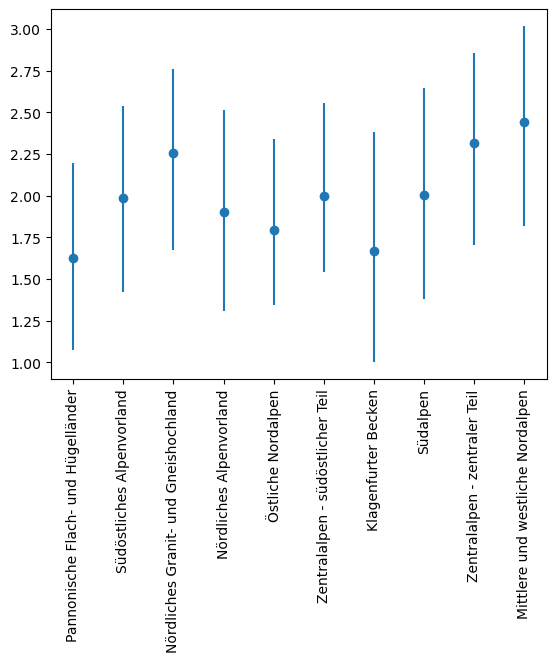

In [19]:
# beta of aspect 
aspect_classes = ["N", "NE", "E", "SE", "S", "SW", "W", "NW"]
forest_types = ["coniferous non pine", "coniferous with mixed pine", "pine pure", "coniferous deciduous mixed with pine", 
                "coniferous_deciduous_mixed_non_pine", "deciduous pure", "low and no vegetation"]

def plot_beta_per_class(coeff: str, classes: list, xrot: int, hdi_prob: float = 0.95):
    betas = st_blr_idata.posterior[coeff].mean(axis=(0, 1, 3, 4)).values
    beta_hdi_95 = az.hdi(st_blr_idata.posterior[coeff].mean(axis=(0, 3, 4)).values, hdi_prob=hdi_prob)
    plt.vlines(classes, beta_hdi_95[:, 1], beta_hdi_95[:, 0])
    plt.scatter(classes, betas)
    plt.xticks(rotation=xrot)
    plt.show()

def plot_beta_per_season(coeff: str, hdi_prob: float = 0.95):
    season_types = ["spring", "summer", "autumn", "winter"]
    coeff_beta = st_blr_idata.posterior[coeff].mean(axis=(0, 1, 2)).values
    beta_hdi_95 = az.hdi(st_blr_idata.posterior[coeff].mean(axis=(0, 2)).values, hdi_prob=hdi_prob)
    plt.vlines(season_types, beta_hdi_95[:, 1], beta_hdi_95[:, 0])
    plt.scatter(season_types, coeff_beta)
    plt.show()

def plot_beta_per_naturraum(coeff: str, xrot: int, hdi_prob: float = 0.95):
    naturräume = ['Pannonische Flach- und Hügelländer', 'Südöstliches Alpenvorland',
       'Nördliches Granit- und Gneishochland', 'Nördliches Alpenvorland',
       'Östliche Nordalpen', 'Zentralalpen - südöstlicher Teil',
       'Klagenfurter Becken', 'Südalpen', 'Zentralalpen - zentraler Teil',
       'Mittlere und westliche Nordalpen']
    coeff_beta = st_blr_idata.posterior[coeff].mean(axis=(0, 1, 3)).values
    beta_hdi_95 = az.hdi(st_blr_idata.posterior[coeff].mean(axis=(0, 3)).values, hdi_prob=hdi_prob)
    plt.vlines(naturräume, beta_hdi_95[:, 1], beta_hdi_95[:, 0])
    plt.scatter(naturräume, coeff_beta)
    plt.xticks(rotation=xrot)
    plt.show()
    

# plot_beta_per_class("beta_forest_type", forest_types, 90)
# plot_beta_per_class("beta_aspect", aspect_classes, 0)
# plot_beta_per_season("beta_population")
plot_beta_per_naturraum("beta_ffmc", 90)
# plot_beta_per_season("beta_ffmc")

#### Analyze relationship between scores & uncertainties


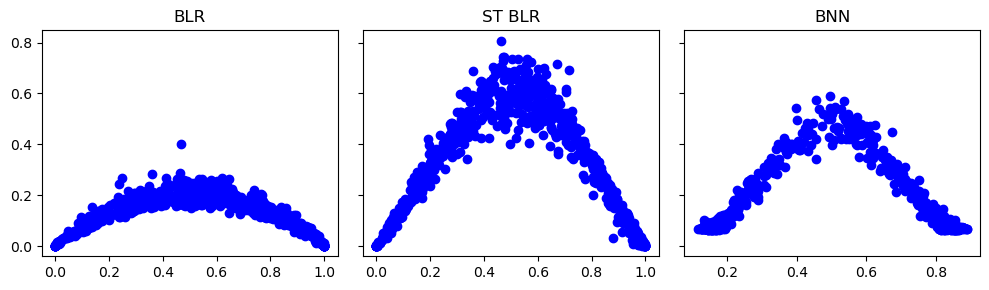

In [20]:
# Create subplots
fig, axs = plt.subplots(1, 3, figsize=(10, 3), sharey=True)

# Plot data on each subplot
axs[0].scatter(blr_preds.p_pred, blr_preds.hdi_width, color='blue')
axs[0].set_title('BLR')

axs[1].scatter(st_blr_preds.p_pred, st_blr_preds.hdi_width, color='blue')
axs[1].set_title('ST BLR')

axs[2].scatter(bnn_preds.p_pred, bnn_preds.hdi_width, color='blue')
axs[2].set_title('BNN')

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()

##### Analyze performance & uncertainty of out-of-sample predictions (per Naturregion & season)

In [21]:
def calculate_accuracy(group):
    return accuracy_score(group.y_true, group.y_pred)

def calculate_precision(group):
    return precision_score(group.y_true, group.y_pred)

def calculate_recall(group):
    return recall_score(group.y_true, group.y_pred)

def prepare_prediction_data(pred_df: pd.DataFrame, y_test: pd.Series, training_data: pd.DataFrame):
    """set index of predictions to match training data and enrich predictions with additional"""
    pred_df.index = y_test.index
    pred_df["y_true"] = y_test
    pred_df_final = training_data.loc[:, ["date", "Pufferradi", "season", "naturraumregionen_encoded", "geometry"]].join(pred_df)
    pred_df_final.dropna(subset="y_true", inplace=True)
    pred_df_final.Pufferradi = pred_df_final.Pufferradi.astype("float")
    return pred_df_final

def group_prediction_data(pred_df, group_var: str):
    """group predictions by group_var and calculate performance metrics and mean uncertainty for each group"""

    agg_funcs = {
        'y_true': 'count',  
        'hdi_width': 'mean',  
        'Pufferradi': 'mean',
    }

    pred_df_grouped = pred_df.groupby(group_var).agg(agg_funcs)
    pred_df_grouped.rename(columns={'y_true': 'count', 'hdi_width': 'hdi_width_mean', 'Pufferradi': 'Pufferradi_mean'}, inplace=True)

    # Group by specific columns and apply the custom function to two columns
    grp_accuracy = pred_df.groupby(group_var).apply(lambda x: calculate_accuracy(x))
    grp_precision = pred_df.groupby(group_var).apply(lambda x: calculate_precision(x))
    grp_recall = pred_df.groupby(group_var).apply(lambda x: calculate_recall(x))

    pred_df_grouped_performance = pd.concat([grp_accuracy, grp_precision, grp_recall], axis=1)
    pred_df_grouped_performance.columns = ["accuracy", "precision", "recall"]

    pred_df_grouped = pred_df_grouped.join(pred_df_grouped_performance)
    return pred_df_grouped

In [22]:
blr_pred_df_prep = prepare_prediction_data(blr_preds, y_test, training_data)
st_blr_pred_df_prep = prepare_prediction_data(st_blr_preds, y_test, training_data)
bnn_pred_df_prep = prepare_prediction_data(bnn_preds, y_test, training_data)

# Calculate mean uncertainty and prediction performance for season subgroups
blr_pred_df_grouped_season = group_prediction_data(blr_pred_df_prep, "season")
st_blr_pred_df_grouped_season = group_prediction_data(st_blr_pred_df_prep, "season")
bnn_pred_df_grouped_season = group_prediction_data(bnn_pred_df_prep, "season")

# Calculate mean uncertainty and prediction performance for naturregion subgroups
blr_pred_df_grouped_naturregion = group_prediction_data(blr_pred_df_prep, "naturraumregionen_encoded")
st_blr_pred_df_grouped_naturregion = group_prediction_data(st_blr_pred_df_prep, "naturraumregionen_encoded")
bnn_pred_df_grouped_naturregion = group_prediction_data(bnn_pred_df_prep, "naturraumregionen_encoded")
